# Sparkify 项目

学员：陈勤 2020年3月28日

## 定义

### 项目概览
数字音乐服务平台（如网易云音乐、QQ音乐）通过网页、桌面应用和移动应用为用户提供在线音乐服务。用户使用服务过程中，会产生诸如听歌、添加歌单、交友、点击广告、升级VIP和注销等庞大的行为日志。此项目旨在通过抽取日志相关性特征来预测客户流失情况。

我认为在线音乐服务的产品逻辑：
- 用户需要注册一个账号成为普通用户，可以点播平台提供的免费歌曲，平台向用户展示广告，赚取收入用于平台运营
- 使用初期平台为用户推荐平台热门歌曲和用户，用户可以把歌曲加入歌单、评价歌曲和交友。通过社交行为增加用户粘性和提升平台活跃度
- 使用一段时间以后，平台为用户推荐有相似听歌行为的用户和分类歌曲
- 用户建立了使用喜好和社交圈后，平台向用户展示需要升级成为VIP用户才可以点播的歌曲（如明星艺术家和无损音乐）和特权（社交虚拟道具），吸引用户成为付费用户
- 出于多种原因，付费用户可能从付费降级为免费，也有可能从免费升级为付费，最糟糕的就是注销，那么用户将从平台流失，这是平台要极力避免的


预测客户流失率是数据科学家和分析师在面向消费者的一类公司中经常遇到的一项具有挑战性的问题。还有，能用 Spark 高效处理大数据集是数据领域职位急需的一种能力。

完整的数据集大小为 12GB，通过分析完整数据集的子集（小数据集），使用Spark 集群的时候，把成果迁移到大数据集上。

### 问题概述
1.把大数据集加载到 Spark 上，并使用 Spark SQL 和 Spark 数据框来操作数据

2.对数据进行清理、整理

3.对数据进行探索性分析

4.提取相关性特征

5.在 Spark ML 中使用机器学习 API 来搭建和调整模型

### 衡量指标
流失用户相对于整体用户的基数非常小（类似于从信用卡用户中找出失信用户），使用F1分数作为优化指标。实现精度和召回率平衡的模型

# 加载和清洗数据

In [1]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import desc
from pyspark.sql.functions import asc
from pyspark.sql.functions import sum as Fsum
from pyspark.sql import Window
from pyspark.ml.feature import RegexTokenizer, VectorAssembler, Normalizer, StandardScaler
from pyspark.sql.functions import avg, col, concat, count, desc, asc, explode, lit, split, stddev, udf, isnan, when, rank, from_unixtime
import datetime

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("sparkify") \
    .getOrCreate()

In [3]:
path = "mini_sparkify_event_data.json"
df = spark.read.json(path)
df.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')

In [18]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [19]:
df.count()

286500

## 评估

In [12]:
# 观察字符列有那些 数值列有那些
num_cols = []
cat_cols = []

for s in df.schema:
    data_type = str(s.dataType)
    if data_type == "StringType":
        cat_cols.append(s.name)
    
    if data_type == "LongType" or data_type == "DoubleType":
        num_cols.append(s.name)

In [13]:
num_cols

['itemInSession', 'length', 'registration', 'sessionId', 'status', 'ts']

In [14]:
cat_cols

['artist',
 'auth',
 'firstName',
 'gender',
 'lastName',
 'level',
 'location',
 'method',
 'page',
 'song',
 'userAgent',
 'userId']

In [27]:
df.select("artist").dropDuplicates().sort("artist").show()

+--------------------+
|              artist|
+--------------------+
|                null|
|                 !!!|
|        & And Oceans|
|'N Sync/Phil Collins|
|        'Til Tuesday|
| 't Hof Van Commerce|
|'t Hof Van Commer...|
|       (Love) Tattoo|
|          (hed) p.e.|
|*NSYNC featuring ...|
|  + / - {Plus/Minus}|
|                 +44|
|          -123 minut|
|            -123min.|
|       ...And Oceans|
|...And You Will K...|
|           1 40 4 20|
|1 Giant Leap feat...|
|1 Giant Leap feat...|
|1 Giant Leap feat...|
+--------------------+
only showing top 20 rows



`artist`列有空值

In [28]:
df.select("firstName").dropDuplicates().sort("firstName").show()

+----------+
| firstName|
+----------+
|      null|
|  Adelaida|
|    Adrian|
|   Adriana|
|    Adriel|
|   Ainsley|
|      Alex|
| Alexander|
|Alexandria|
|     Alexi|
|    Alyssa|
|   Alyssia|
| Amberlynn|
|    Andrew|
|     Angel|
|     Anika|
|      Anna|
| Annabella|
|  Antonina|
|   Antonio|
+----------+
only showing top 20 rows



`firstName`列有空值

In [29]:
df.select("gender").dropDuplicates().sort("gender").show()

+------+
|gender|
+------+
|  null|
|     F|
|     M|
+------+



`gender`列有空值

In [31]:
df.select("lastName").dropDuplicates().sort("lastName").show()

+---------+
| lastName|
+---------+
|     null|
|    Adams|
|  Aguilar|
|Alexander|
|    Allen|
| Atkinson|
|   Bailey|
|    Baker|
|     Ball|
|   Barnes|
|  Barnett|
|     Beck|
|  Bennett|
|     Bird|
|    Boone|
|  Bradley|
|   Brooks|
|    Brown|
|  Burgess|
|  Cabrera|
+---------+
only showing top 20 rows



`lastName`列有空值

In [32]:
df.select("level").dropDuplicates().sort("level").show()

+-----+
|level|
+-----+
| free|
| paid|
+-----+



`level`列数据完整

In [34]:
df.select("location").dropDuplicates().sort("location").show()

+--------------------+
|            location|
+--------------------+
|                null|
|          Albany, OR|
|Albany-Schenectad...|
|      Alexandria, LA|
|Allentown-Bethleh...|
|       Anchorage, AK|
|Atlanta-Sandy Spr...|
|Atlantic City-Ham...|
|Austin-Round Rock...|
|     Bakersfield, CA|
|Baltimore-Columbi...|
|        Billings, MT|
|Birmingham-Hoover...|
|Boston-Cambridge-...|
|         Boulder, CO|
|         Bozeman, MT|
|Bridgeport-Stamfo...|
|Buffalo-Cheektowa...|
|Charlotte-Concord...|
|Chicago-Napervill...|
+--------------------+
only showing top 20 rows



`location`列有空值

In [35]:
df.select("method").dropDuplicates().sort("method").show()

+------+
|method|
+------+
|   GET|
|   PUT|
+------+



`method`列数据完整

In [36]:
df.select("page").dropDuplicates().sort("page").show()

+--------------------+
|                page|
+--------------------+
|               About|
|          Add Friend|
|     Add to Playlist|
|              Cancel|
|Cancellation Conf...|
|           Downgrade|
|               Error|
|                Help|
|                Home|
|               Login|
|              Logout|
|            NextSong|
|            Register|
|         Roll Advert|
|       Save Settings|
|            Settings|
|    Submit Downgrade|
| Submit Registration|
|      Submit Upgrade|
|         Thumbs Down|
+--------------------+
only showing top 20 rows



`page`列数据完整

In [37]:
df.select("song").dropDuplicates().sort("song").show()

+--------------------+
|                song|
+--------------------+
|                null|
|ÃÂg ÃÂtti Gr...|
| I Will Not Reap ...|
|              !@*$%#|
|#!*@ You Tonight ...|
|                  #1|
|#1 Fan [Feat. Key...|
|           #1 Stunna|
|                 #16|
| #18 (Album Version)|
|#2 For Prepared W...|
|                 #24|
|  #4 (Album Version)|
|                 #40|
|                   $|
|       $1000 Wedding|
|$87 And A Guilty ...|
|                $in$|
|       $timulus Plan|
|              & Down|
+--------------------+
only showing top 20 rows



`song`列有缺失值

In [39]:
df.select("userAgent").dropDuplicates().sort("userAgent").show()

+--------------------+
|           userAgent|
+--------------------+
|                null|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Win...|
|"Mozilla/5.0 (Win...|
+--------------------+
only showing top 20 rows



`userAgent`列有缺失值

In [40]:
df.select("userId").dropDuplicates().sort("userId").show()

+------+
|userId|
+------+
|      |
|    10|
|   100|
|100001|
|100002|
|100003|
|100004|
|100005|
|100006|
|100007|
|100008|
|100009|
|100010|
|100011|
|100012|
|100013|
|100014|
|100015|
|100016|
|100017|
+------+
only showing top 20 rows



`userId`列包含空字符串

In [20]:
# 定义一个数据完整性校验的函数
def count_missing(df, col):
    """
    对数据集中指定列的空值进行计数：空值定义如下：
    
    1. NaN
    2. Null
    3. "" (空串)
    """
    return df.filter((isnan(df[col])) | (df[col].isNull()) | (df[col] == "")).count()

In [21]:
# 打印数据集的完整性统计信息
print("[missing values]\n")
for col in df.columns:
    missing_count = count_missing(df, col)
    if missing_count > 0:
        print("{}: {}".format(col, missing_count))

[missing values]

artist: 58392
firstName: 8346
gender: 8346
lastName: 8346
length: 58392
location: 8346
registration: 8346
song: 58392
userAgent: 8346
userId: 8346


#### 评估统计信息

数据集共有286500条记录，包含的特征如下：

- `artist`:创作歌曲的艺术家名字，有**228108**条记录
- `auth`:记录登录状态,数据完整无缺失
- `firstName`:用户名,有**2278154**条记录
- `gender`:性别,有**2278154**条记录
- `itemInSession`:当前会话中id,数据完整无缺失
- `lastName`:用户姓,有**2278154**条记录
- `length`:歌曲长度,有**2228108**条记录
- `level`:区分用户付费还是免费，数据完整无缺失
- `location`:用户地理位置,有**2278154**条记录
- `method`:数据上行还是下行,数据完整无缺失
- `page`:用户访问的页面,数据完整无缺失
- `registration`:注册时间,有**2278154**条记录
- `sessionId`:会话id,数据完整无缺失
- `song`:歌曲名,有**2228108**条记录
- `status`:用户访问页面的http状态码,数据完整无缺失
- `ts`:日志流水时间,数据完整无缺失
- `userAgent`用户访问使用的浏览器信息,数据完整无缺失
- `userId`用户id,数据完整无缺失

从观测值来看，数据分为两个维度：

- 从获取到的用户信息来看，有2278154条记录，而userId数据又是完整的，意味着有userId是无效的
- 从获取到的歌曲信息来看，有228108条记录，这个是可以接受，毕竟用户不是每一次行为都是听歌

### 质量
- `userId`列没有空值，但存在**空字符串**,为无效的用户ID
- `auth`、`level`、`method`、`page`、`itemInSession`、`sessionId`、`status`、`ts`列没有空值，数据完整
- `userAgent`,`registration`,`location`,`firstName`,`lastName`,`gender`列数据存在缺失值，条数都为278154条
- `artist`、`song`、`length`存在缺失值，条数都为228108

### 清洗
- 清洗0：去除`userId`为空字符串的数据

In [4]:
df_clean = df.dropna(how = "any", subset = ["userId", "sessionId"])
df_clean = df.filter(df["userId"] != "")
print("原始数据集记录数:                    {}".format(df.count()))
print("无userId缺失记录数: {}".format(df_clean.count())) # no missing values

if df.count() == df_clean.count():
    print("userId 和 sessionId 没有缺失值")
else:
    print("{} 行无效数据被移除.".format(df.count() - df_clean.count()))

原始数据集记录数:                    286500
无userId缺失记录数: 278154
8346 行无效数据被移除.


In [41]:
# 打印清洗后数据集的完整性统计信息
print("[missing values]\n")
for col in df_clean.columns:
    missing_count = count_missing(df_clean, col)
    if missing_count > 0:
        print("{}: {}".format(col, missing_count))

[missing values]

artist: 50046
length: 50046
song: 50046


清洗完`userId`列为空值的数据后，数据条数与`userAgent`,`registration`,`location`,`firstName`,`lastName`,`gender`列一致了

`artist`、`song`、`length`为歌曲的播放信息，用户并非每个动作都是听歌，所以存在缺失值是可以接受的

# 探索性数据分析


用户访问页面的行为有：
- `About`:点击应用的说明
- `Add Friend`:添加好友
- `Add to Playlist`: 添加播放歌单
- `Cancel`:查看注销页
- `Cancellation Confirmation`:确定注销
- `Downgrade`:查看降级页
- `Error`:访问错误
- `Help`:查看帮助页
- `Home`:查看主页
- `Logout`:登出
- `NextSong`:播放下一首歌曲
- `Roll Advert`:滚动广告
- `Save Settings`:保存设置
- `Settings`:访问设置
- `Submit Downgrade`:确定降级
- `Submit Upgrade`:确定升级
- `Thumbs Down`:撤下当前头像
- `Thumbs Up`:上传头像
- `Upgrade`:查看升级页

## 探索思路：
1.使用 Cancellation Confirmation 行为来定义客户流失

2.提取我认为的与客户流失有较强相关的特征绘制图表观察

3.从图表分析结果中最终确定用于机器学习的特征

In [7]:
df_clean.select("page").dropDuplicates().sort("page").show(30)

+--------------------+
|                page|
+--------------------+
|               About|
|          Add Friend|
|     Add to Playlist|
|              Cancel|
|Cancellation Conf...|
|           Downgrade|
|               Error|
|                Help|
|                Home|
|              Logout|
|            NextSong|
|         Roll Advert|
|       Save Settings|
|            Settings|
|    Submit Downgrade|
|      Submit Upgrade|
|         Thumbs Down|
|           Thumbs Up|
|             Upgrade|
+--------------------+



使用 Cancellation Confirmation 事件来定义客户流失

In [43]:
df_clean.select("userId").filter("page = 'Cancellation Confirmation'").sort("userId").show(5)

+------+
|userId|
+------+
|100001|
|100003|
|100005|
|100006|
|100007|
+------+
only showing top 5 rows



### 定义客户流失

创建一列 `Churn` 作为模型的标签。使用 `Cancellation Confirmation` 事件来定义客户流失，该事件在付费或免费客户身上都有发生。

In [5]:
# 定义客户流失标记函数 1 为流失 0 为存留
flag_cancelled_event = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())
# 创建列Churn 
df_clean = df_clean.withColumn("churn", flag_cancelled_event("page"))

日志的时间都是timestamp类型，通过转换格式来观察时间日期

In [6]:
# 创建提取年月日的函数
get_year = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000, None).strftime("%Y"), StringType())
get_month = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000, None).strftime("%m"), StringType())
get_day = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000, None).strftime("%d"), StringType())
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000, None).strftime("%H"), StringType())

In [7]:
# 拆分流水时间为年月日小时
df_clean = df_clean.withColumn("tsyear", get_year(df_clean.ts))
df_clean = df_clean.withColumn("tsmonth", get_month(df_clean.ts))
df_clean = df_clean.withColumn("tsday", get_day(df_clean.ts))
df_clean = df_clean.withColumn("tshour", get_hour(df_clean.ts))

观察一个流失用户的行为

In [11]:
df_clean.select(["userId", "tsyear", "tsmonth", "tsday", "tshour", "page", "level", "churn"]).filter(df_clean.userId == "100001").sort(desc("ts")).collect()

[Row(userId='100001', tsyear='2018', tsmonth='10', tsday='02', tshour='16', page='Cancellation Confirmation', level='free', churn=1),
 Row(userId='100001', tsyear='2018', tsmonth='10', tsday='02', tshour='16', page='Cancel', level='free', churn=0),
 Row(userId='100001', tsyear='2018', tsmonth='10', tsday='02', tshour='16', page='Roll Advert', level='free', churn=0),
 Row(userId='100001', tsyear='2018', tsmonth='10', tsday='02', tshour='16', page='NextSong', level='free', churn=0),
 Row(userId='100001', tsyear='2018', tsmonth='10', tsday='02', tshour='16', page='Home', level='free', churn=0),
 Row(userId='100001', tsyear='2018', tsmonth='10', tsday='02', tshour='16', page='Logout', level='free', churn=0),
 Row(userId='100001', tsyear='2018', tsmonth='10', tsday='02', tshour='16', page='NextSong', level='free', churn=0),
 Row(userId='100001', tsyear='2018', tsmonth='10', tsday='02', tshour='16', page='NextSong', level='free', churn=0),
 Row(userId='100001', tsyear='2018', tsmonth='10', t

### 探索数据
从观察数据中来看，每一条日志记录了用户的一个动作，我决定采用page特征做为最主要的探索对象，将page中的重要动作提取出来进行独热编码

In [8]:
# 定义标记用户交友的函数
flag_frenid_event = udf(lambda x: 1 if x == "Add Friend" else 0, IntegerType())
# 创建列friend
df_clean = df_clean.withColumn("friend", flag_frenid_event("page"))

# 定义标记用户添加歌单的动作
flag_addplaylist_event = udf(lambda x: 1 if x == "Add to Playlist" else 0, IntegerType())
# 创建列addplaylist
df_clean = df_clean.withColumn("addplaylist", flag_addplaylist_event("page"))

# 定义标记用户注销动作
flag_cancel_event = udf(lambda x: 1 if x == "Cancel" else 0, IntegerType())
# 创建列cancel
df_clean = df_clean.withColumn("cancel", flag_cancel_event("page"))

# 定义客户有降级动作的函数
flag_downgrade_action = udf(lambda x: 1 if x == "Downgrade" else 0, IntegerType())
df_clean = df_clean.withColumn("downgrade", flag_downgrade_action("page"))

# 定义标记用户访问错误的动作
flag_error_event = udf(lambda x: 1 if x == "Error" else 0, IntegerType())
# 创建列error
df_clean = df_clean.withColumn("error", flag_error_event("page"))

# 定义标记用户点击帮助的动作
flag_help_event = udf(lambda x: 1 if x == "Help" else 0, IntegerType())
# 创建列error
df_clean = df_clean.withColumn("help", flag_help_event("page"))

# 定义用户登出的函数
flag_logout_event = udf(lambda x: 1 if x == "Logout" else 0, IntegerType())
# 创建列logout
df_clean = df_clean.withColumn("logout", flag_logout_event("page"))

# 定义标记用户听歌的函数
flag_song_event = udf(lambda x: 1 if x == "NextSong" else 0, IntegerType())
# 创建列song
df_clean = df_clean.withColumn("song", flag_song_event("page"))

# 定义标记用户升级动作的函数
flag_upgrade_action = udf(lambda x: 1 if x == "Upgrade" else 0, IntegerType())
# 创建列upgrade
df_clean = df_clean.withColumn("upgrade", flag_upgrade_action("page"))

# 定义标记用户升级的函数
flag_upgrade_event = udf(lambda x: 1 if x == "Submit Upgrade" else 0, IntegerType())
# 创建列upgraded
df_clean = df_clean.withColumn("upgraded", flag_upgrade_event("page"))

# 定义标记客户降级的函数
flag_downgrade_event = udf(lambda x: 1 if x == "Submit Downgrade" else 0, IntegerType())
# 创建列downgraded
df_clean = df_clean.withColumn("downgraded", flag_downgrade_event("page"))

# 定义标记客户滚动广告的函数
flag_advert_event = udf(lambda x: 1 if x == "Roll Advert" else 0, IntegerType())
# 创建列dadvert
df_clean = df_clean.withColumn("advert", flag_advert_event("page"))

# 定义收费免费标志
flag_level_event = udf(lambda x: 1 if x == "paid" else 0, IntegerType())
df_clean = df_clean.withColumn("lv", flag_level_event("level"))


编码完成后，增加了12个特征，并进行了独热编码：

1.`friend`:用户的交友行为

2.`addplaylist`:用户添加歌单的行为

3.`cancel`:用户想要注销的行为

4.`downgrade`:用户想要降级的行为

5.`error`:用户访问发生错误的行为

6.`help`:用户访问帮助页面的行为

7.`logout`:用户登出的行为

8.`upgrade`:用户想要升级的行为

9.`upgraded`:用户确定升级的事件

10.`downgraded`:用户确定降级的事件

11.`advert`:用户点击广告的行为

12.`lv`:标识用户付费还是免费

按用户分组，汇总所有的行为和事件，在此过程中，发现听歌的事件在数量级上远大于其他事件，决定废弃听歌事件，以免对其他特征干扰太大

In [9]:
import seaborn as sns
sns.set_color_codes("pastel")
sns.set_style("whitegrid")

In [10]:
df_clean.createOrReplaceTempView("user_log_table")

In [12]:
# 将用户的动作汇总
user_acts = spark.sql('''SELECT  userId, 
                                 level,
                                 sum(churn) as churn,
                                 sum(friend) as friend,
                                 sum(addplaylist) as addplaylist,
                                 sum(cancel) as cancel,
                                 sum(downgrade) as downgrade,
                                 sum(error) as error,
                                 sum(help) as help,
                                 sum(logout) as logout,
                                 sum(advert) as advert,
                                 sum(upgrade) as upgrade,
                                 sum(upgraded) as upgraded,
                                 sum(downgraded) as downgraded
                           from  user_log_table
                       group by  userId, level ''')

In [13]:
pd_user_acts = user_acts.toPandas()
pd_user_acts.head()

,userId,level,churn,friend,addplaylist,cancel,downgrade,error,help,logout,advert,upgrade,upgraded,downgraded
0,100021,free,1,7,7,1,0,2,0,7,30,2,0,0
1,200021,free,0,8,2,0,0,0,1,8,9,3,1,0
2,200001,free,1,0,3,1,0,0,1,4,3,1,0,0
3,6,free,0,2,4,0,0,0,0,2,4,1,1,0
4,300022,paid,0,11,9,0,1,0,3,5,0,0,0,0


In [14]:
pd_user_acts.describe()

,churn,friend,addplaylist,cancel,downgrade,error,help,logout,advert,upgrade,upgraded,downgraded
count,360.000000,360.000000,360.000000,360.000000,360.000000,360.000000,360.000000,360.000000,360.000000,360.000000,360.000000,360.000000
mean,0.144444,11.880556,18.127778,0.144444,5.708333,0.700000,4.038889,8.961111,10.925000,1.386111,0.441667,0.175000
std,0.352029,16.219925,25.826188,0.352029,10.272387,1.163033,5.499925,11.231851,18.096844,2.289208,0.673359,0.483646
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,3.000000,0.000000,0.000000,0.000000,1.000000,2.000000,1.000000,0.000000,0.000000,0.000000
50%,0.000000,6.000000,8.000000,0.000000,0.000000,0.000000,2.000000,5.000000,3.000000,0.000000,0.000000,0.000000
75%,0.000000,15.250000,24.250000,0.000000,8.250000,1.000000,5.000000,12.000000,14.000000,2.000000,1.000000,0.000000
max,1.000000,122.000000,205.000000,1.000000,73.000000,7.000000,32.000000,86.000000,118.000000,15.000000,4.000000,3.000000


#### 探索存留用户与流失用户的行为对比

##### 1.探索存留用户与流失用户的付费数量

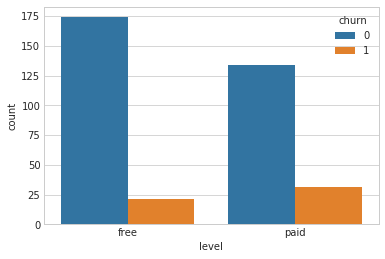

In [15]:
sns.countplot(x="level", hue="churn", data=pd_user_acts);

从统计结果来看，付费用户的流失人数高于免费用户的流失人数

##### 2.探索存留用户与流失用户的交友人数

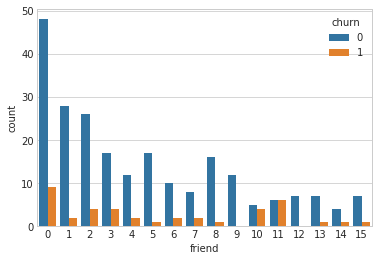

In [27]:
pd_friend = pd_user_acts[(pd_user_acts.friend >= pd_user_acts.friend.quantile(0.15)) \
                         & (pd_user_acts.friend <= pd_user_acts.friend.quantile(0.75)) ]
sns.countplot(x="friend", hue="churn", data=pd_friend);

从统计结果来看
- 75%的用户交友人数不超过15人
- 存留用户的交友人数高于流失用户的交友人数

##### 3.探索存留用户与流失用户的添加歌单次数

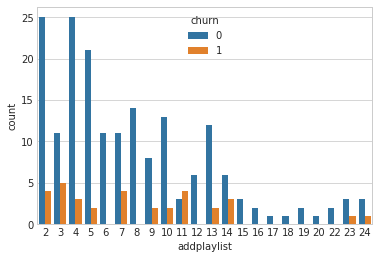

In [28]:
pd_addplaylist= pd_user_acts[(pd_user_acts.addplaylist >= pd_user_acts.addplaylist.quantile(0.15)) \
                         & (pd_user_acts.addplaylist <= pd_user_acts.addplaylist.quantile(0.75)) ]
sns.countplot(x="addplaylist", hue="churn", data=pd_addplaylist);

从统计结果来看
- 75%的用户添加歌单小于25次
- 存留用户的添加歌单次数高于流失用户的添加歌单次数

##### 4.探索存留用户与流失用户点击注销页面的次数

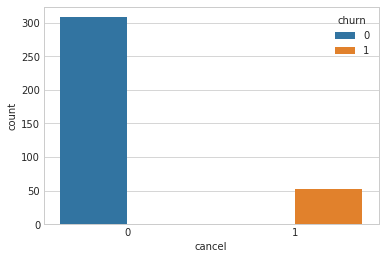

In [100]:
pd_cancel= pd_user_acts[(pd_user_acts.cancel >= pd_user_acts.cancel.quantile(0.05)) \
                         & (pd_user_acts.cancel <= pd_user_acts.cancel.quantile(0.95)) ]
sns.countplot(x="cancel", hue="churn", data=pd_cancel);

从统计结果来看，存留用户点击注销页面次数高于流失用户点击注销页面次数

##### 5.探索存留用户与流失用户点击降级页面的次数

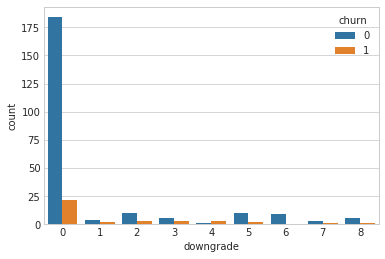

In [97]:
pd_downgrade= pd_user_acts[(pd_user_acts.downgrade >= pd_user_acts.downgrade.quantile(0.15)) \
                         & (pd_user_acts.downgrade <= pd_user_acts.downgrade.quantile(0.75)) ]
sns.countplot(x="downgrade", hue="churn", data=pd_downgrade);

从统计结果来看
- 没有点击过降级页面的用户也发生了流失
- 存留用户点击降级页面次数高于流失用户点击降级页面次数

##### 6.探索存留用户与流失用户点击广告的次数

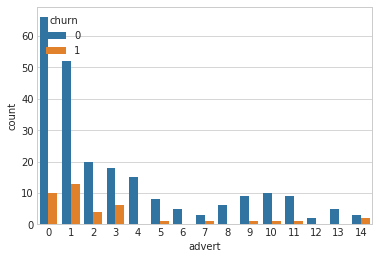

In [101]:
pd_advert= pd_user_acts[(pd_user_acts.advert >= pd_user_acts.advert.quantile(0.15)) \
                         & (pd_user_acts.advert <= pd_user_acts.advert.quantile(0.75)) ]
sns.countplot(x="advert", hue="churn", data=pd_advert);

从统计结果来看
- 75%客户点击广告的次数不超过15次
- 存留用户点击广告次数高于流失用户点击广告次数

#### 探索存留用户与流失用户的行为对比结论
- 存留用户的行为次数要高于流失用户，这可能与流失用户的基数较小有关
- 大部分用户的听歌和社交占比并不高

#### 探索免费用户的行为

In [56]:
user_acts_sub = pd_user_acts[pd_user_acts.lv == 0].iloc[:,3:]
# 创建百分比
user_acts_sub = user_acts_sub.div(user_acts_sub.sum(axis=1), axis=0)

Text(0,0.5,'count')

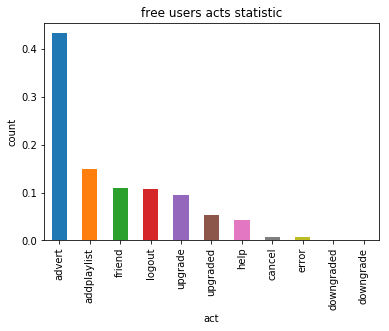

In [57]:
user_acts_sub.mean().sort_values(ascending = False).plot.bar()

plt.title("free users acts statistic")
plt.xlabel("act")
plt.ylabel("count")

In [ ]:
sns.countplot(x="level", hue="churn", data=pd_level);

#### 探索免费流失用户的行为

In [58]:
user_acts_sub = pd_user_acts[(pd_user_acts.lv == 0) & (pd_user_acts.churn == 1)].iloc[:,3:]
# 创建百分比
user_acts_sub = user_acts_sub.div(user_acts_sub.sum(axis=1), axis=0)

Text(0,0.5,'count')

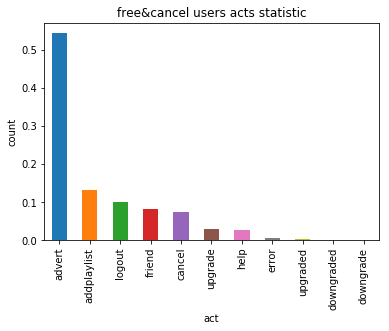

In [60]:
user_acts_sub.mean().sort_values(ascending = False).plot.bar()

plt.title("free&cancel users acts statistic")
plt.xlabel("act")
plt.ylabel("count")

从免费用户的统计图表来看：
- 广告点击事件的占比远高于其他事件
- 流失客户交友的占比低于存留用户
- 流失客户想要注销的占比高于存留客户

#### 探索付费用户的行为

In [62]:
user_acts_sub = pd_user_acts[pd_user_acts.lv == 1].iloc[:,3:]
# 创建百分比
user_acts_sub = user_acts_sub.div(user_acts_sub.sum(axis=1), axis=0)

Text(0,0.5,'count')

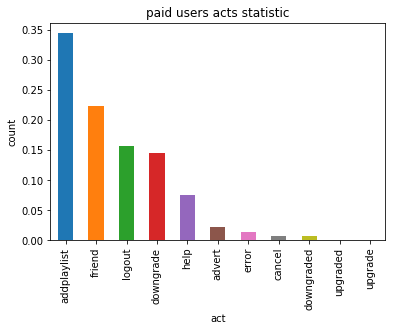

In [63]:
user_acts_sub.mean().sort_values(ascending = False).plot.bar()

plt.title("paid users acts statistic")
plt.xlabel("act")
plt.ylabel("count")

探索付费用户的统计图表，发现一个有意思的事，广告对用户的干扰占比很小，添加歌曲和交友占比变高起来

#### 探索付费用户降级的行为

Text(0,0.5,'count')

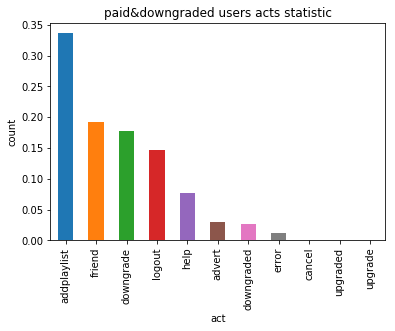

In [64]:
user_acts_sub = pd_user_acts[(pd_user_acts.lv == 1) & (pd_user_acts.downgraded > 0)].iloc[:,3:]
# 创建百分比
user_acts_sub = user_acts_sub.div(user_acts_sub.sum(axis=1), axis=0)
user_acts_sub.mean().sort_values(ascending = False).plot.bar()

plt.title("paid&downgraded users acts statistic")
plt.xlabel("act")
plt.ylabel("count")

从付费用户发生降级行为的统计图表来看：
- 点击降级页面的占比高于整体付费用户水平
- 最终发生降低的占比高于整体付费用户水平

#### 探索付费用户流失的行为

Text(0,0.5,'count')

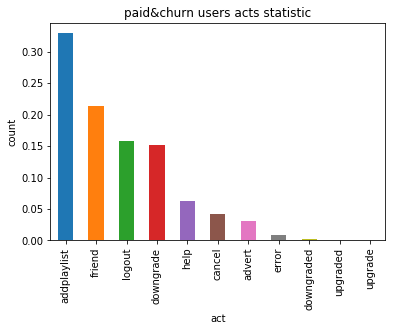

In [65]:
user_acts_sub = pd_user_acts[(pd_user_acts.lv == 1) & (pd_user_acts.churn == 1)].iloc[:,3:]
# 创建百分比
user_acts_sub = user_acts_sub.div(user_acts_sub.sum(axis=1), axis=0)
user_acts_sub.mean().sort_values(ascending = False).plot.bar()

plt.title("paid&churn users acts statistic")
plt.xlabel("act")
plt.ylabel("count")

从付费用户最终流失的客户来看，想要降级和注销动作的占比高于整体付费用户水平

#### 探索用户升级的行为

Text(0,0.5,'count')

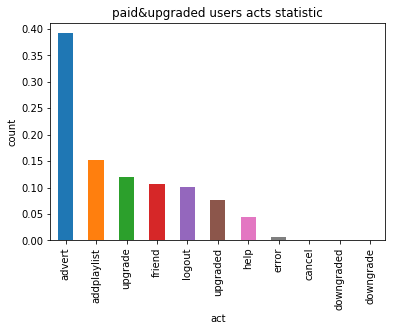

In [15]:
user_acts_sub = pd_user_acts[(pd_user_acts.lv == 0) & (pd_user_acts.upgraded > 0)].iloc[:,3:]
# 创建百分比
user_acts_sub = user_acts_sub.div(user_acts_sub.sum(axis=1), axis=0)
user_acts_sub.mean().sort_values(ascending = False).plot.bar()

plt.title("paid&upgraded users acts statistic")
plt.xlabel("act")
plt.ylabel("count")

从最终升级为付费用户的免费用户来看，想要升级的动作占比高较高

### 结论
- 广告是影响免费用户使用的一个关键特征
- 用户想要发生某种事件时，点击相关页面的占比比较高
- 添加歌单的行为在整体行为中占比高，我决定不使用其作为机器学习模型的特征

# 特征工程
最终选定做为机器学习特征如下：

1.`friend`:用户的交友行为

2.`cancel`:用户想要注销的行为

3.`downgrade`:用户想要降级的行为

4.`error`:用户访问发生错误的行为

5.`help`:用户访问帮助页面的行为

6.`upgrade`:用户想要升级的行为

7.`upgraded`:用户确定升级的事件

8.`advert`:用户点击广告的行为

9.`lv`:标识用户付费还是免费

除了`lv`特征保留1和0（1标识用户付费 0标识用户免费），其余特征按用户分组后，按时间顺序进行相加，做为关键特征的值

想要达到的效果如：2018年1月1日用户点击广告的日志，`adverts`特征计数为1，2018年1月2日用户点击广告的日志，`adverts`特征计数为2。其他特征也如此

处理完成后，对特征进行归一化，最终创建一个叫做`scaledfeatures2`的向量，用于机器学习

In [16]:
windowval = Window.partitionBy("userId").orderBy(asc("ts")).rangeBetween(Window.unboundedPreceding, 0)
# 创建列交友行为累计
df_clean = df_clean.withColumn("friends", Fsum("friend").over(windowval))


In [17]:
# 创建列广告点击行为累计
df_clean = df_clean.withColumn("adverts", Fsum("advert").over(windowval))

In [18]:
# 创建列降级动作累计
df_clean = df_clean.withColumn("downgrades", Fsum("downgrade").over(windowval))

In [19]:
# 创建列注销动作累计
df_clean = df_clean.withColumn("cancels", Fsum("cancel").over(windowval))

In [20]:
# 创建列升级动作累计
df_clean = df_clean.withColumn("upgrades", Fsum("upgrade").over(windowval))

In [21]:
# 创建列降级累计
df_clean = df_clean.withColumn("phase", Fsum("downgraded").over(windowval))

In [22]:
# 创建列帮助动作累计
df_clean = df_clean.withColumn("helps", Fsum("help").over(windowval))

In [23]:
# 创建列错误页累计
df_clean = df_clean.withColumn("errors", Fsum("error").over(windowval))

In [24]:
# 将关键特征转换为向量
assembler = VectorAssembler(inputCols=[ "lv", "friends", "adverts", "downgrades", "cancels", "upgrades", "helps", "errors" , "phase"], outputCol="features")
df_clean = assembler.transform(df_clean)

In [25]:
# 将向量进行归一化
scaler = Normalizer(inputCol="features", outputCol="scaledfeatures")
df_clean = scaler.transform(df_clean)

In [26]:
# 用标准差缩小值
scaler2 = StandardScaler(inputCol="scaledfeatures", outputCol="scaledfeatures2", withStd=True)
scalerModel = scaler2.fit(df_clean)
df_clean = scalerModel.transform(df_clean)

In [117]:
df_clean.select(["userId", "tsyear", "tsmonth", "tsday", "scaledfeatures2", "churn"]).filter(df_clean.userId == "100001").sort(desc("ts")).collect()

[Row(userId='100001', tsyear='2018', tsmonth='10', tsday='02', scaledfeatures2=DenseVector([0.0, 0.4998, 2.7777, 0.0, 22.3883, 1.4515, 0.486, 1.2227, 0.0]), churn=1),
 Row(userId='100001', tsyear='2018', tsmonth='10', tsday='02', scaledfeatures2=DenseVector([0.0, 0.4998, 2.7777, 0.0, 22.3883, 1.4515, 0.486, 1.2227, 0.0]), churn=0),
 Row(userId='100001', tsyear='2018', tsmonth='10', tsday='02', scaledfeatures2=DenseVector([0.0, 0.501, 2.7845, 0.0, 0.0, 1.4551, 0.4872, 1.2257, 0.0]), churn=0),
 Row(userId='100001', tsyear='2018', tsmonth='10', tsday='02', scaledfeatures2=DenseVector([0.0, 0.5375, 2.7737, 0.0, 0.0, 1.5609, 0.5227, 1.3149, 0.0]), churn=0),
 Row(userId='100001', tsyear='2018', tsmonth='10', tsday='02', scaledfeatures2=DenseVector([0.0, 0.5375, 2.7737, 0.0, 0.0, 1.5609, 0.5227, 1.3149, 0.0]), churn=0),
 Row(userId='100001', tsyear='2018', tsmonth='10', tsday='02', scaledfeatures2=DenseVector([0.0, 0.5375, 2.7737, 0.0, 0.0, 1.5609, 0.5227, 1.3149, 0.0]), churn=0),
 Row(userId

从上面的数据片段可以看到，`scaledfeatures2`特征已创建完毕

# 建模

**最终需要解决的问题是一个二分类问题**

模型选择决定采用逻辑回归和决策树先进行尝试，如果预测效果不好，再选择其他模型

- 逻辑回归模型:调整的参数先尝试`regParam`，使用0和0.1进行网格搜索

- 决策树模型：调整的参数先尝试`maxDepth`，使用5和10进行网格搜索

流失用户相对于整体用户的基数非常小，使用F1分数作为优化指标。实现精度和召回率平衡的模型

操作步骤如下：

1.将完整数据集分成训练集、测试集和验证集

2.使用逻辑回归模型进行测试，得到f1分数和学习时间

3.使用决策树模型进行测试，得到f1分数和学习时间

4.比较两种模型的准确率，如果两种模型的f1分数低于0.9，尝试选择其他模型；如果效果较好，比较两个模型的学习效率

In [118]:
from pyspark.ml.regression import LinearRegression
from pyspark.sql.functions import col

In [119]:
data = df_clean.select(col("churn").alias("label"), col("scaledfeatures2").alias("features"))
data.head()

Row(label=0, features=SparseVector(9, {}))

In [120]:
rest, validation = data.randomSplit([0.9, 0.1], seed=42)

In [121]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import DecisionTreeClassifier


In [153]:
def getBestParam(cvModel):
    params = cvModel.getEstimatorParamMaps()
    avgMetrics = cvModel.avgMetrics

    all_params = list(zip(params, avgMetrics))
    best_param = sorted(all_params, key=lambda x: x[1], reverse=True)[0]
    return best_param

In [124]:
lr =  LogisticRegression(maxIter=10, regParam=0.0, elasticNetParam=0)
paramGrid = ParamGridBuilder().addGrid(lr.regParam,[0.0, 0.1]).build()

f1_score = MulticlassClassificationEvaluator(metricName = 'f1')


crossval = CrossValidator(estimator=lr,
                          estimatorParamMaps=paramGrid,
                          evaluator=f1_score,
                          numFolds=3)

CrossValidator使用三次折叠，将生成三个（训练，测试）数据集对，每个对都使用2/3的数据进行训练，并使用1/3的数据进行测试，当数据集比较小的是否交叉验证可以“充分利用”有限的数据找到合适的模型参数，防止过度拟合

In [125]:
%%time
cvModel_q1 = crossval.fit(rest)

CPU times: user 3.03 s, sys: 797 ms, total: 3.83 s
Wall time: 4min 54s


In [154]:
best_param = getBestParam(cvModel_q1)
print(best_param[0])

{Param(parent='LogisticRegression_5aee873a4077', name='regParam', doc='regularization parameter (>= 0).'): 0.0}


逻辑回归模型的最佳超参数为regParam=0.0

In [155]:
results = cvModel_q1.transform(validation)

In [156]:
from time import time
# 查看结果
# 时间也是衡量模型好坏的一个标准
evaluator = MulticlassClassificationEvaluator(predictionCol = 'prediction')
print("逻辑回归分数:")
start = time()
print("准确度: {}".format(evaluator.evaluate(results, {evaluator.metricName:'accuracy'})))
print("f1分数: {}".format(evaluator.evaluate(results, {evaluator.metricName:'f1'})))
end = time()
print("验证集计算准确度与f1分数用时 {}秒".format(end - start))

逻辑回归分数:
准确度: 0.9997849231100119
f1分数: 0.9996773962307786
验证集计算准确度与f1分数用时 53.09775471687317秒


In [157]:

dt = DecisionTreeClassifier(labelCol="label", featuresCol="features")

paramGrid = ParamGridBuilder().addGrid(dt.maxDepth,[5, 10]).build()
f1_score = MulticlassClassificationEvaluator(metricName = 'f1')

crossval = CrossValidator(estimator=dt,
                          estimatorParamMaps=paramGrid,
                          evaluator=f1_score,
                          numFolds=3)

CrossValidator使用三次折叠，将生成三个（训练，测试）数据集对，每个对都使用2/3的数据进行训练，并使用1/3的数据进行测试，当数据集比较小的是否交叉验证可以“充分利用”有限的数据找到合适的模型参数，防止过度拟合

In [158]:
%%time
cvModel_q1 = crossval.fit(rest)

CPU times: user 2.54 s, sys: 601 ms, total: 3.14 s
Wall time: 4min 35s


In [159]:
best_param = getBestParam(cvModel_q1)
print(best_param[0])

{Param(parent='DecisionTreeClassifier_9f5166b6c5d5', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 5}


逻辑回归模型的最佳超参数为maxDepth=5

In [160]:
results = cvModel_q1.transform(validation)

In [161]:
from time import time
# 查看结果
# 时间也是衡量模型好坏的一个标准
evaluator = MulticlassClassificationEvaluator(predictionCol = 'prediction')
print("决策树分数:")
start = time()
print("准确度: {}".format(evaluator.evaluate(results, {evaluator.metricName:'accuracy'})))
print("f1分数: {}".format(evaluator.evaluate(results, {evaluator.metricName:'f1'})))
end = time()
print("验证集计算准确度与f1分数用时 {}秒".format(end - start))

决策树分数:
准确度: 0.9996773846650178
f1分数: 0.999623624117308
验证集计算准确度与f1分数用时 51.14030480384827秒


## 建模结论
1.逻辑回归模型的f1分数为0.9997，训练时间为4分54秒，验证集预测时间用时50.8秒

2.决策树模型的f1分数为0.9996，训练时间为4分35秒，验证集预测时间用时50.1秒

3.两个模型都非常棒，几乎没有差别，虽然逻辑回归模型的训练时间略高于决策树模型，但f1分数更高，因此我决定使用逻辑回归做为本项目使用的最终模型

## 挑战与反思
- 将用户的访问事件作为特征，难点在于需要将`page`特征提取每个事件作为特征，因此写了不少函数来提取
- 在特征工程处理时，如果使用特征的独热编码，则特征的值比较稀疏，采用日志的独热编码值逐条相加再设置为特征值，是我认为处理最为成功的地方，结果也验证了这一想法，获得了不错的f1分数
- 在特征选取中，也许忽略了一些相关性，如用户的听歌和添加歌单行为（我认为数量级太大影响其他特征），以及用户从注册到流失的存留时间是否也是一个关键因素，也是值得探索性分析的部分